In [1]:
import numpy as np

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


import scipy.io as io

from sklearn.decomposition import PCA

from scipy.spatial.distance import hamming


from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

import os

from FlagRep import FlagRep
import tqdm

# Anomaly Detection

## 5 PCs

In [5]:

base_path = '../../FlagDimensionalityReduction/data/AD_CampsValls/'
f_name = 'TexasCoast.mat'

print('-------------------------------------')

print('-------------------------------------')

print('-------------------------------------')

print('-------------------------------------')

data = io.loadmat(os.path.join(base_path, f_name))

X = data["Y"]
labels = data['labels'].flatten()

#mean center data
column_means = np.mean(X, axis=0)
Xcenter = X - column_means

-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------


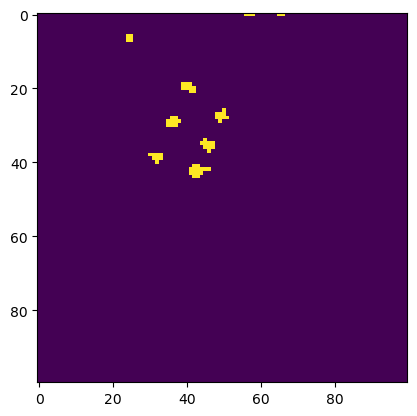

In [6]:
plt.imshow(data['labels'])

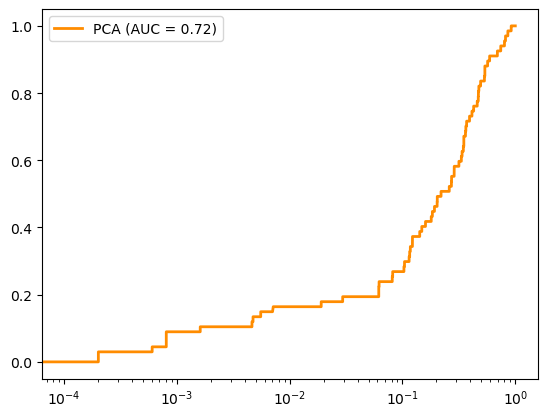

In [7]:


U,_,_ = np.linalg.svd(Xcenter, full_matrices=False)
Wpca = U[:,:5]

Xrec = Wpca @ Wpca.T @ Xcenter

errs = np.linalg.norm(Xcenter- Xrec, axis = 1)**2
pca_preds = errs/errs.max()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, pca_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'PCA (AUC = {roc_auc:.2f})')
plt.xscale('log')
plt.legend()

In [8]:
def flag_diagnostic(D, p, step_size, Aset_end):
    the_As = []
    errs = []
    ns = []
    for n_1 in range(step_size,p,step_size): #loop through every feature combination between {1,2,...,n_1} \subset {1,...,220}
        As = [np.arange(n_1)]+Aset_end
        the_As.append(As)

        my_flag_rep = FlagRep(Aset = As, solver = 'irls svd')
        Q,R = my_flag_rep.decompose(D)
        print(my_flag_rep.flag_type())

        errs.append(np.linalg.norm(Q @ R - D))
        ns.append(n_1)

    plt.figure()
    plt.plot(ns, errs)

    return ns[np.argmin(errs)]


[ 10 100 204]
[ 20 100 204]
[ 30 100 204]
[ 40 100 204]
[ 50 100 204]
[ 60 100 204]
[ 70 100 204]
[ 80 100 204]
[ 90 100 204]


80

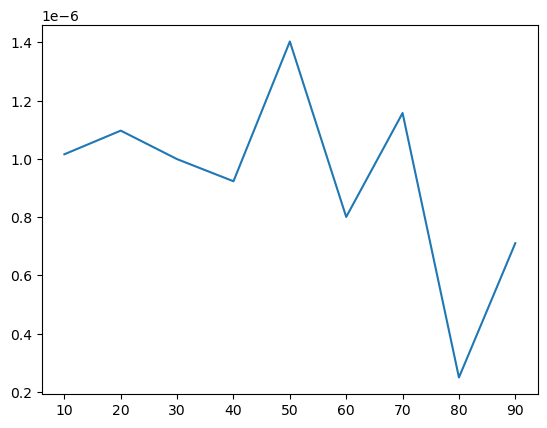

In [9]:
flag_diagnostic(X, 100, 10, [np.arange(100),np.arange(204)])

In [12]:
def ordered_partitions_of_size_k(n, k):
    result = []

    # Helper function to recursively find partitions
    def partition(n, k, current_partition):
        if k == 0:
            if n == 0:
                result.append(current_partition)
            return

        for i in range(1, n - k + 2):  # Ensure enough remaining space for remaining parts
            partition(n - i, k - 1, current_partition + [i])

    # Call the recursive partition function
    partition(n, k, [])
    
    return result

# Example usage for n = 5 and k = 2
n = 5
k = 3
partitions = ordered_partitions_of_size_k(n, k)
flag_types = [np.cumsum(p) for p in partitions]

In [15]:
from tqdm import tqdm
errs = []
for f_type in tqdm(flag_types):
    my_flag_rep = FlagRep(Aset = [np.arange(80),np.arange(100),np.arange(204)], flag_type = f_type, solver = 'irls svd')
    Q,R = my_flag_rep.decompose(X)
    errs.append(np.linalg.norm(Q @ R - X))
print(flag_types[np.argmin(errs)])

100%|██████████| 6/6 [12:19<00:00, 123.26s/it]

[3 4 5]


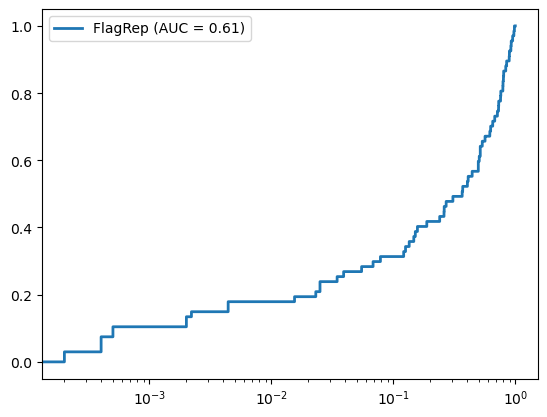

In [16]:
my_flag_rep = FlagRep(Aset = [np.arange(80),np.arange(100),np.arange(204)], flag_type = [3,4,5], solver = 'irls svd')
Q,R = my_flag_rep.decompose(X)


Xrec = Q @ R

errs = np.linalg.norm(Xcenter- Xrec, axis = 1)**2
flagrep_preds = errs/errs.max()


# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, flagrep_preds)
roc_auc = auc(fpr, tpr)


# Plot ROC curve
plt.plot(fpr, tpr, lw=2, label=f'FlagRep (AUC = {roc_auc:.2f})')
plt.xscale('log')
plt.legend()

100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


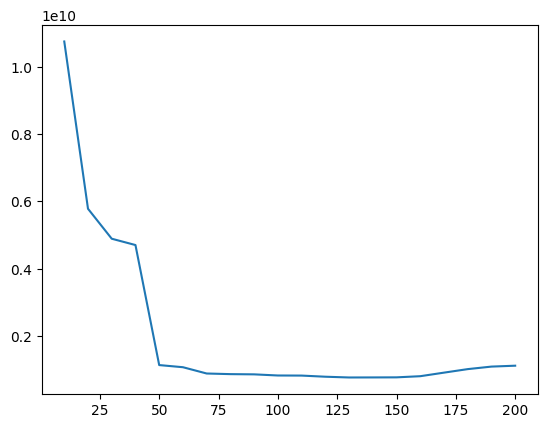

In [18]:


test_dims = np.arange(10,204,10)
rec_errs = []
aucs = []
for i in tqdm.tqdm(test_dims):
    my_flag_rep = FlagRep(Aset = [np.arange(i), np.arange(204)], flag_type=[4,5])
    Q, R = my_flag_rep.decompose(Xcenter)

    Xrec = Q @ R

    errs = np.linalg.norm(Xcenter- Xrec, axis = 1)**2
    rec_errs.append(np.sum(errs))
    flagrep_preds = errs/errs.max()

test_dims[np.argmin(rec_errs)]

plt.plot(test_dims, rec_errs)

# # Compute ROC curve and AUC
# fpr, tpr, thresholds = roc_curve(labels, flagrep_preds)
# roc_auc = auc(fpr, tpr)
# aucs.append(roc_auc)

# # Plot ROC curve
# plt.plot(fpr, tpr, lw=2, label=f'FlagRep({i},204) (AUC = {roc_auc:.2f})')
# plt.legend()



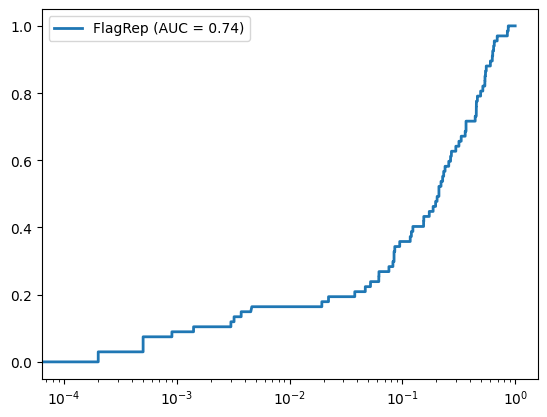

In [21]:
my_flag_rep = FlagRep(Aset = [np.arange(test_dims[np.argmin(rec_errs)]), np.arange(204)], flag_type=[4,5])
Q, R = my_flag_rep.decompose(Xcenter)

Xrec = Q @ R

errs = np.linalg.norm(Xcenter- Xrec, axis = 1)**2
flagrep_preds = errs/errs.max()


# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, flagrep_preds)
roc_auc = auc(fpr, tpr)


# Plot ROC curve
plt.plot(fpr, tpr, lw=2, label=f'FlagRep (AUC = {roc_auc:.2f})')
plt.xscale('log')
plt.legend()

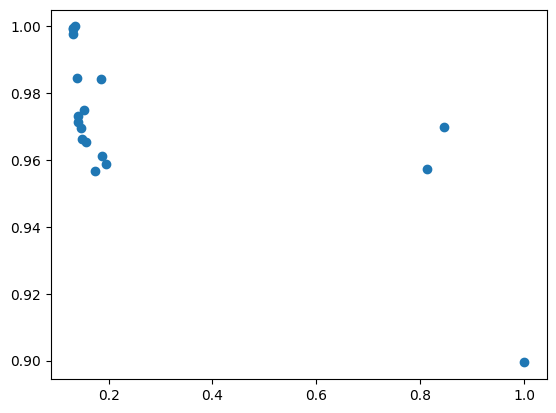

In [13]:
plt.figure()
plt.scatter(np.array(rec_errs)/np.array(rec_errs).max(), np.array(aucs)/np.array(aucs).max())

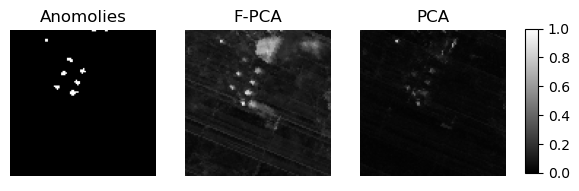

In [14]:

labels_im = data['labels']
im_shape = labels_im.shape
pca_errs_im  = np.reshape(pca_preds, newshape = im_shape).T
fpca_errs_im  = np.reshape(fpca_preds, newshape = im_shape).T


ims = [labels_im, fpca_errs_im, pca_errs_im]
titles = ['Anomalies', f'F-PCA', f'PCA']

# Create a figure with subplots
fig, axs = plt.subplots(1,3)

# Loop through the images and add them to subplots
implts = []
for i, im, title in zip(range(len(ims)), ims, titles):
    
    # Display the grayscale image with imshow
    implts.append( axs[i].imshow(im, cmap='gray'))
    axs[i].set_title(title)
    axs[i].axis('off')


norm = plt.Normalize(vmin=np.min([ims[0], ims[1], ims[2]]), vmax=np.max([ims[0], ims[1], ims[2]]))
implts[0].set_norm(norm)
implts[1].set_norm(norm)
implts[2].set_norm(norm)

cax = fig.add_axes([0.93, 0.35, 0.02, 0.3])  # [x, y, width, height]
cbar = plt.colorbar(implts[0], cax=cax)
